# Σύστημα εντοπισμού αναξιόπιστων άρθρων ειδήσεων

Import των απαιτούμενων βιβλιοθηκών

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
import time
import joblib
from matplotlib import pyplot as plt
import seaborn as sns


Φόρτωση και προεπεξεργασία των δεδομένων που θα χρησιμοποιηθούν για την εκπαίδευση και τον έλεγχο του μοντέλου.

In [2]:
# read csv
df=pd.read_csv('train.csv')

# counting the number of missing values in the dataset
df.isnull().sum()

# replacing the null values with empty string
df = df.fillna('')

# merging the author name and news title
df['content'] = df['author']+' '+df['title']+' '+df['text']

# separating the data & label
X = df['content']
Y = df['label']

In [3]:
print(X.head())
print(Y.head())

0    Darrell Lucus House Dem Aide: We Didn’t Even S...
1    Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2    Consortiumnews.com Why the Truth Might Get You...
3    Jessica Purkiss 15 Civilians Killed In Single ...
4    Howard Portnoy Iranian woman jailed for fictio...
Name: content, dtype: object
0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64


Συνέχεια προεπεξεργασίας: 
Ορισμός της συνάρτησης stemming η οποία εκτελεί τα εξής βήματα όσον αφορά την προεπεξεργασία του κειμένου:
1. Το περιεχόμενο κειμένου καθαρίζεται αφαιρώντας τυχόν χαρακτήρες που δεν είναι γράμματα (a-z ή A-Z) αντικαθιστώντας τους με έναν χαρακτήρα διαστήματος.
2. Στη συνέχεια, το καθαρισμένο κείμενο μετατρέπεται σε πεζά.
3. Tο καθαρισμένο κείμενο χωρίζεται σε μεμονωμένες λέξεις.
4. Στη συνέχεια, οι λέξεις τροποποιούνται χρησιμοποιώντας το αντικείμενο PorterStemmer,που είναι ένα εργαλείο για τη μείωση των λέξεων στη βάση ή τη ρίζα τους.
5. Τα stopwords αφαιρούνται από τη λίστα των λέξεων.
6. Τέλος, οι επεξεργασμένες λέξεις ενώνονται ξανά μεταξύ τους σε μια ενιαία συμβολοσειρά.

In [4]:
nltk.download('stopwords')

# printing the stopwords in English
print(stopwords.words('english'))

port_stem = PorterStemmer()

def stemming(content):
    review = re.sub('[^a-zA-Z]',' ',content)
    review = review.lower()
    review = review.split()
    review = [port_stem.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
X = X.apply(stemming)

#separating the data and label
X = X.values
Y = Y.values

# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

print(X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

(20800, 111501)


Αποθήκευση του vectorizer, ώστε να χρησιμοποιηθεί στην εφαρμογή.

In [6]:
# Save the vectorizer
joblib.dump(vectorizer, 'vectorizer.joblib')

['vectorizer.joblib']

Εκπαίδευση με την χρήση του αλγορίθμου λογιστικής παλινδρόμησης και υπολογισμός του χρόνου εκτέλεσης

In [7]:
start_time_LR = time.time()

model_LR = LogisticRegression()
model_LR.fit(X_train, Y_train)

print("Training time for Logistic Regression model is: {:.2f} seconds".format(time.time() - start_time_LR))

Training time for Logistic Regression model is: 1.44 seconds


Αποθήκευση του εκπαιδευμένου μοντέλου λογιστικής παλινδρόμησης.

In [8]:
joblib.dump(model_LR, "model_LR.joblib")

['model_LR.joblib']

In [9]:
X_test.shape

(4160, 111501)

Ακρίβεια ταξινόμησης του μοντέλου λογιστικής παλινδρόμησης και χρόνος που χρειάστηκε για να εκτελεστεί το μοντέλο και να κατηγοριοποιήσει τα δεδομένα ελέγχου.

Accuracy score of the training data :  0.9798677884615384
Accuracy score of the test data :  0.9543269230769231
Time to return predictions for 4160 new articles is : 0.006999 seconds



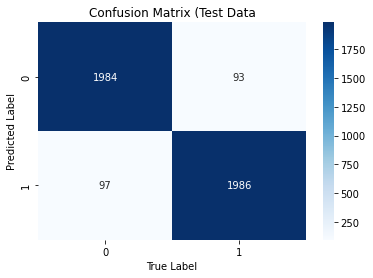

In [10]:
# accuracy score on the training data
y_train_pred = model_LR.predict(X_train)
training_data_accuracy = accuracy_score(y_train_pred, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy)

start_time_LR_getpreds = time.time()
# accuracy score on the test data
y_test_pred = model_LR.predict(X_test)
test_data_accuracy = accuracy_score(y_test_pred, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy)
print("Time to return predictions for 4160 new articles is : {:.6f} seconds".format(time.time() - start_time_LR_getpreds))

cm_test = confusion_matrix(Y_test, y_test_pred)
print()
sns.heatmap(cm_test, annot=True, fmt='d',cmap='Blues')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix - (Test Data')
plt.show()

Εκπαίδευση με την χρήση του Support Vector Classifier.

In [11]:
start_time_svc = time.time()

model_svc = svm.SVC()
model_svc.fit(X_train, Y_train)

print("Training time for Support Vector Classifier model is: {:.2f} seconds".format(time.time() - start_time_svc))

Training time for Support Vector Classifier model is: 689.91 seconds


In [12]:
joblib.dump(model_svc, "model_svc.joblib")

['model_svc.joblib']

Υπολογισμός ακρίβειας μοντέλου SVC.

Accuracy score of the training data :  0.9986177884615385
Accuracy score of the test data :  0.9663461538461539
Time to return predictions for 4160 new articles is : 58.744752 seconds



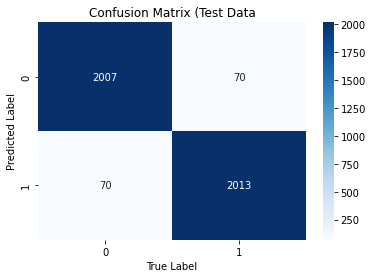

In [13]:
# accuracy score on the training data
y_train_pred = model_svc.predict(X_train)
training_data_accuracy = accuracy_score(y_train_pred, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy)

start_time_LR_getpreds = time.time()
# accuracy score on the test data
y_test_pred = model_svc.predict(X_test)
test_data_accuracy = accuracy_score(y_test_pred, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy)
print("Time to return predictions for 4160 new articles is : {:.6f} seconds".format(time.time() - start_time_LR_getpreds))

cm_test = confusion_matrix(Y_test, y_test_pred)
print()
sns.heatmap(cm_test, annot=True, fmt='d',cmap='Blues')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix (Test Data')
plt.show()